## Accessing Sentinel-2 data on Azure

The [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) program provides global imagery in thirteen spectral bands at 10m-60m resolution and a revisit time of approximately five days.  This dataset represents the global Sentinel-2 archive, from 2016 to the present, processed to L2A (bottom-of-atmosphere) using [Sen2Cor](https://step.esa.int/main/snap-supported-plugins/sen2cor/) and converted to [cloud-optimized GeoTIFF](https://www.cogeo.org/) format.

This notebook demonstrates access to Sentinel-2 data on Azure, using sentinelsat to query the Copernicus Open Access Hub for scenes, then accessing the scenes on Azure blob storage.  Using this approach, the user needs to provide storage credentials.  To access the Copernicus Open Access Hub for spatiotemporal search, the user also needs to provide Open Access Hub credentials.  An alternative approach that eliminates both of these requirements is to use the Planetary Computer API, demonstrated [here](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook).

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented at [aka.ms/ai4edata-sentinel-2](http://aka.ms/ai4edata-sentinel-2).

### Environment setup

In [1]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

import rasterio
from rasterio.windows import Window
from pyproj import Transformer        

from sentinelsat import SentinelAPI
from azure.storage.blob import ContainerClient

### Constants

In [2]:
# This can be either a SAS token or a file with a SAS token on the first line
sentinel2_sas_token = os.path.expanduser('~/tokens/sentinel2_sas.txt')

# A text file with a login on the first line, password on the second line
copernicus_credentials_file = os.path.expanduser('~/tokens/coah_username_password.txt')

# Or specify username/password
username = None; password = None

# Copernicus API query parameters
api_url = 'https://scihub.copernicus.eu/dhus'
platform_name = 'Sentinel-2'

# Query just L1C scenes; L2A scenes have the same timestamps/geometries
product_type = 'S2MSI1C'

# Query parameters

# Around Jonah Bay, Alaska
lat = 61.00212860030653
lon = -147.7789234838648

# Format point as WKT
footprint = 'POINT({:.4f} {:.4f})'.format(lon,lat)
start_time = datetime.datetime(2019,6,1,0,0,0)
end_time = datetime.datetime(2019,8,1,0,0,0)
max_cloud_cover_percent = 5

# Scaling constant that controls rendering brightness
preview_norm_value = 1500

# When rendering whole images, how much should we downscale?
preview_downsample_factor = 20

# Select channels for our composite
channels = ['_B04','_B03','_B02']

# Target image size and "zoom factor"
target_size = [720,405]
oversample = 12.5

# Scaling constant that controls rendering brightness
composite_norm_value = 3000

### Create sentinel-2 container client

In [3]:
if os.path.isfile(sentinel2_sas_token):
    lines = []
    with open(sentinel2_sas_token,'r') as f:
        lines = f.readlines()
    assert len(lines) >= 1
    sentinel2_sas_token = lines[0].strip()

sentinel2_storage_account_name = 'sentinel2l2a01'
sentinel2_container_name = 'sentinel2-l2'

sentinel2_storage_account_url = 'https://' + sentinel2_storage_account_name + '.blob.core.windows.net/'

sentinel2_container_client = ContainerClient(account_url=sentinel2_storage_account_url, 
                                             container_name=sentinel2_container_name,
                                             credential=sentinel2_sas_token)

### Load username/pw for Open Access Hub

In [4]:
if copernicus_credentials_file is not None:

    assert username is None 
    assert password is None    

    lines = []
    with open(copernicus_credentials_file,'r') as f:
        lines = f.readlines()
    assert len(lines) >= 2
    
    username = lines[0].strip()
    password = lines[1].strip()

### Connect to the Open Access Hub API

In [5]:
api = SentinelAPI(user=username, password=password, api_url=api_url)

### Query for scenes

In [6]:
products = api.query(footprint,
                     producttype=product_type,
                     date=(start_time,end_time),
                     platformname=platform_name,
                     cloudcoverpercentage=(0, max_cloud_cover_percent))

product_values = list(products.values())
    
print('Found {} scenes:'.format(len(products)))
for p in product_values:
    print(p['filename'])

# For the rest of this notebook, we'll use the first returned result
product = product_values[0]   

Found 2 scenes:
S2B_MSIL1C_20190706T211519_N0207_R143_T06VVN_20190706T225149.SAFE
S2B_MSIL1C_20190629T212529_N0207_R043_T06VVN_20190629T230241.SAFE


### Map to Azure paths

In [7]:
# For the product:
#
# S2B_MSIL1C_20190730T190919_N0208_R056_T10UEU_20190730T210627.SAFE
#    
# Our path is:
#    
# https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2
#
# /10/U/EU/2019/07/30/S2B_MSIL2A_20190730T190919_N0212_R056_T10UEU_20201005T200819.SAFE/
#
# This part is unique and can be determined from the scene metadata:
#
# /10/U/EU/2019/07/30/S2B_MSIL2A_20190730T190919

# E.g. '10UEU'
tile_id = product['tileid']

utm_lon_zone = tile_id[0:2]
mgrs_lat_band = tile_id[2]
tile_chunk = tile_id[3:5]

scene_date = product['datatakesensingstart']
scene_year = str(scene_date.year)
scene_month = str(scene_date.month).zfill(2)
scene_day = str(scene_date.day).zfill(2)

filename = product['filename'].replace('L1C','L2A')
filename = filename[0:26]

azure_scene_prefix = '/'.join([utm_lon_zone,mgrs_lat_band,tile_chunk,scene_year,scene_month,scene_day,filename])

print('Azure scene prefix: {}'.format(azure_scene_prefix))

Azure scene prefix: 06/V/VN/2019/07/06/S2B_MSIL2A_20190706T211519


### List matching blobs, select the three channels we want for RGB rendering

In [8]:
generator = sentinel2_container_client.list_blobs(name_starts_with=azure_scene_prefix)
image_blobs = [blob.name for blob in generator if blob.name.endswith('.tif')]
preview_blobs = [blob.name for blob in generator if blob.name.endswith('.jpeg')]

print('Found {} image files'.format(len(image_blobs)))

# Find three channels in our preferred RGB ordering
channels = ['_B04','_B03','_B02']

rgb_blobs = []
for c in channels:
    for blob_path in image_blobs:
        if c in blob_path:
            rgb_blobs.append(blob_path)
            break

print('\nRendering an RGB composite from the following image files:\n')
assert(len(rgb_blobs) == 3)
for blob_path in rgb_blobs:
    print(blob_path.split('/')[-1])

Found 23 image files

Rendering an RGB composite from the following image files:

T06VVN_20190706T211519_B04_10m.tif
T06VVN_20190706T211519_B03_10m.tif
T06VVN_20190706T211519_B02_10m.tif


### Convert to Azure blob URLs

In [9]:
rgb_urls = []
for blob_path in rgb_blobs:
    rgb_urls.append(sentinel2_storage_account_url + sentinel2_container_name + '/' + blob_path + sentinel2_sas_token)

### Render a composite image for the whole scene

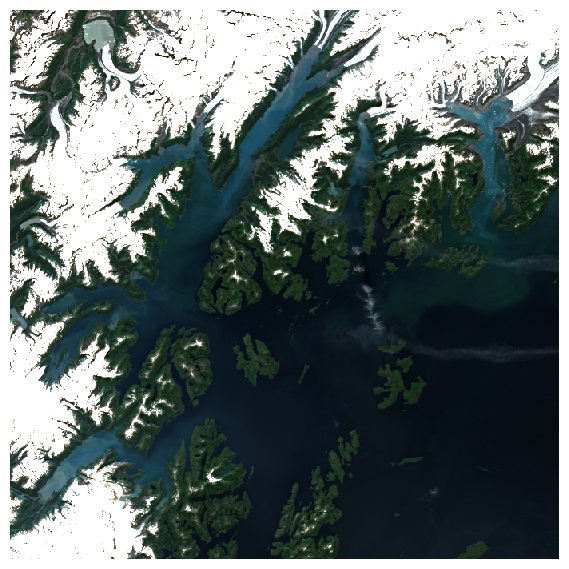

In [10]:
w = None; h = None;
image_data = []

for url in rgb_urls:
    with rasterio.open(url,'r') as raster:        
        h = int(raster.height // preview_downsample_factor)
        w = int(raster.width // preview_downsample_factor)
        
        band_array = raster.read(1, out_shape=(1,h,w))
        raster.close()
        band_array = band_array / composite_norm_value
        image_data.append(band_array)

rgb = np.dstack((image_data[0],image_data[1],image_data[2]))
np.clip(rgb,0,1,rgb)

dpi = 100; fig = plt.figure(frameon=False,figsize=(w/dpi,h/dpi),dpi=dpi)
ax = plt.Axes(fig,[0., 0., 1., 1.]); ax.set_axis_off(); fig.add_axes(ax)

plt.imshow(rgb);

### Crop to our target size around our target point

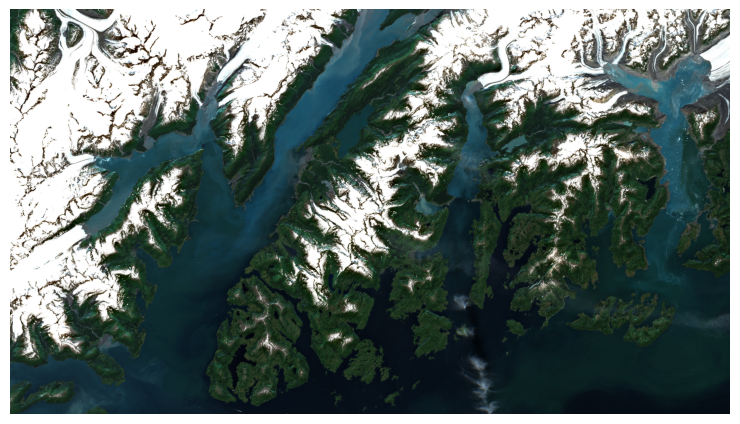

In [11]:
image_data = []

for urls in rgb_urls:
    
    with rasterio.open(urls,'r') as src:
        
        xsize = (target_size[0] * oversample)
        ysize = (target_size[1] * oversample)
                
        transformer = Transformer.from_crs('EPSG:4326', src.crs, always_xy=True)
        xx, yy = transformer.transform(lon, lat)
        py, px = src.index(xx,yy)    
        xoff = px - xsize // 2 
        yoff = py - ysize // 2 
        window = Window(xoff,yoff,xsize,ysize)
        
        band_array = src.read(1, window=window)
        src.close()
        band_array = band_array / composite_norm_value
        image_data.append(band_array)

    # ...with rasterio.open()
    
# ...for each file

rgb = np.dstack((image_data[0],image_data[1],image_data[2]))
np.clip(rgb,0,1,rgb)

w = target_size[0]; h = target_size[1]
dpi = 100; fig = plt.figure(frameon=False,figsize=(w/dpi,h/dpi),dpi=dpi)
ax = plt.Axes(fig,[0., 0., 1., 1.]); ax.set_axis_off(); fig.add_axes(ax)

plt.imshow(rgb);